# Praca domowa z ML numer 10

<a href="https://colab.research.google.com/github/tomczj/ML24_25/blob/main/Convolutional_Neural_Networks/homework_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### UWAGA: W poniższym pliku zamieszczono przerywniki tak, aby zapobiec przypadkowemu odpaleniu się funckji, które się bardzo długo liczą (tj. generowanie animacji).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn.functional as F
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML
import requests

##### Ustalenie ziarna losowości

In [2]:
#ustalamy seed
torch.manual_seed(439669)
np.random.seed(439669)

##### Funkcja do skalowania obrazków

In [3]:
# funckja służąca do przeskalowania obrazku na różne skale szarości

def rescale_0_1(imgs):
    return torch.sigmoid(imgs)  # bo [-2,2] → [0,1]


## Wczytujemy wytrenowaną już sieć neuronową z githuba

#### Ładujemy dane - potrzebne później.

In [4]:
transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)  

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

### Pobieramy model z githuba, jakby były problemy to zakomentować poniższą linijkę i odkomentować pozostałe poniżej.

In [5]:
url = "https://raw.githubusercontent.com/tomczj/ML24_25/main/Convolutional_Neural_Networks/LeNet5_model.pth"

filename = "LeNet5_model.pth"

response = requests.get(url)
response.raise_for_status()

with open(filename, "wb") as f:
    f.write(response.content)

print("Model saved to", filename)

Model saved to LeNet5_model.pth


In [6]:
# class LeNet5(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 6, padding = 2, kernel_size = 5, padding_mode = "replicate")
#         self.avgpool = torch.nn.AvgPool2d(kernel_size = 2, stride = 2)
#         self.relu = torch.nn.ReLU()
#         self.conv2 = torch.nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5)
#         self.conv3 = torch.nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = 5)
#         self.linear1 = torch.nn.Linear(120, 84)
#         self.linear2 = torch.nn.Linear(84, 10)
#         self.dropout = torch.nn.Dropout(0.05)

#     def forward(self, x):               # B, 1, 28, 28

#         x = self.relu(self.conv1(x))    # B, 6, 28, 28
#         x = self.avgpool(x)             # B, 16, 14, 14
#         x = self.relu(self.conv2(x))    # B, 16, 10, 10
#         x = self.avgpool(x)             # B, 16, 5, 5
#         x = self.relu(self.conv3(x))    # B, 120, 1, 1
#         x = x.squeeze(-1).squeeze(-1)   # B, 120, 1 ->  B, 120
#         x = self.relu(self.linear1(x))  # B, 84
#         x = self.linear2(x)             # B, 10            
#         x = self.dropout(x)
#         return x

In [7]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# print(f"Working on {device}")

# net = LeNet5().to(device)
# optimizer = torch.optim.Adam(net.parameters(), 0.001)
# net.train() 
# for epoch in range(16):

#     for batch, data in enumerate(trainloader):
#         batch_inputs, batch_labels = data

#         batch_inputs = batch_inputs.to(device)
#         batch_labels = batch_labels.to(device)

#         optimizer.zero_grad()

#         batch_outputs = net(batch_inputs)  

#         loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean")
#         print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
#         loss.backward()     
#         optimizer.step()    

In [9]:
# good = 0
# wrong = 0

# net.eval()     
# with torch.no_grad():  
#     for batch, data in enumerate(testloader): 
#         datapoint, label = data

#         prediction = net(datapoint.to(device))                 
#         classification = torch.argmax(prediction)  

#         if classification.item() == label.item():
#             good += 1
#         else:
#             wrong += 1

# print("accuracy = ", good/(good+wrong))

In [10]:
# torch.save(net.state_dict(), "LeNet5_model.pth")

### Ładujemy wytrenowany już wcześniej model


In [11]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 6, padding = 2, kernel_size = 5, padding_mode = "replicate")
        self.avgpool = torch.nn.AvgPool2d(kernel_size = 2, stride = 2)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5)
        self.conv3 = torch.nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = 5)
        self.linear1 = torch.nn.Linear(120, 84)
        self.linear2 = torch.nn.Linear(84, 10)
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):               # B, 1, 28, 28

        x = self.relu(self.conv1(x))    # B, 6, 28, 28
        x = self.avgpool(x)             # B, 16, 14, 14
        x = self.relu(self.conv2(x))    # B, 16, 10, 10
        x = self.avgpool(x)             # B, 16, 5, 5
        x = self.relu(self.conv3(x))    # B, 120, 1, 1
        x = x.squeeze(-1).squeeze(-1)   # B, 120, 1 ->  B, 120
        x = self.relu(self.linear1(x))  # B, 84
        x = self.linear2(x)             # B, 10            
        x = self.dropout(x)
        return x

In [12]:
#korzystamy z cpu lub gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#definiujemy model
net = LeNet5()

#pobieramy wytenowany model
net.load_state_dict(torch.load("LeNet5_model.pth"))
net.to(device)

#zamrażamy wagi
net.eval()

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (relu): ReLU()
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=120, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
)

##### Accuracy

In [13]:
good = 0
wrong = 0
 
with torch.no_grad():  
    for batch, data in enumerate(testloader): 
        datapoint, label = data

        prediction = net(datapoint.to(device))                 
        classification = torch.argmax(prediction)  

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9831


## Część 1 - CNN dreams
W tej części pracy wykorzystamy w pewnym stopniu kod z poprzedniej pracy domowej. W szczególności przeprowadzimy proces $\textit{śnienia}$ przez konwolucyjną sieć neuronową i porównamy go z procesem dla MLP z poprzedniego razu.

In [14]:
lambdas = [0, 0.01, 0.1, 1.0, 10.0]

# ilość kroków, które wykonamy (nie potzreba dużo)
steps = 7500
#learnin rate
lr = 0.001

In [15]:
#zaczynamy od szumu gaussowskiego a następnie zmieniamy wartości pikseli tak, aby obrazki przypominały rzeczywiste liczby

#zapisanie obrazków i confidence dla poszczególnych lambd i cyfr
all_images = []
all_confidences = []

#przechodzimy przez wszystkie lambdy
for lambda_l2 in lambdas:
    targets = torch.arange(10, device=device)
    dr_images = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)
    img_opt = torch.optim.Adam([dr_images], lr=lr)

    confidence_over_time = [[] for _ in range(10)] 

    # tutaj rozpoczyna się zmienianie inputu, czyli obrazków przy wykorzystaniu sieci neuronowej
    for step in range(steps):
        img_opt.zero_grad()
        logits = net(dr_images)

        #funkcja straty
        loss = F.cross_entropy(logits, targets) + lambda_l2 * dr_images.pow(2).mean()
        loss.backward()
        img_opt.step()

        #oszacowanie prawdopodobieństw
        with torch.no_grad():
            probs = F.softmax(net(dr_images), dim=1).detach().cpu()
            for i in range(10):
                confidence_over_time[i].append(probs[i].numpy()) 

    final_images = rescale_0_1(dr_images.detach().cpu())
    all_images.append((lambda_l2, final_images))
    all_confidences.append(confidence_over_time)


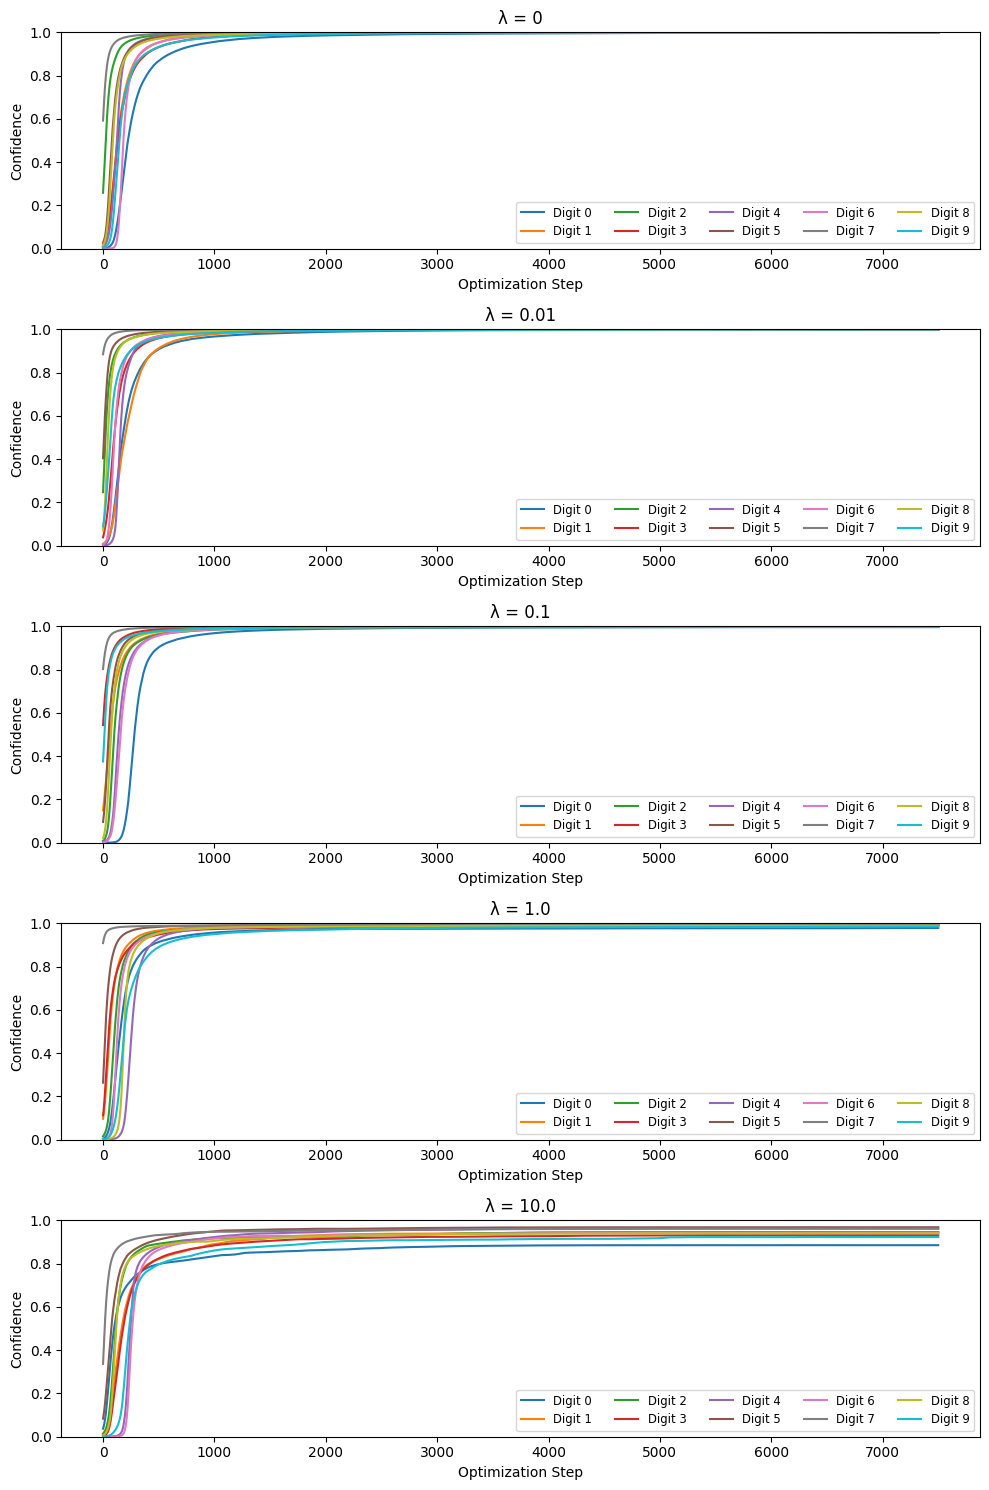

In [16]:
#wykres ewolucji funckji straty

num_lambdas = len(lambdas)
fig, axes = plt.subplots(num_lambdas, 1, figsize=(10, 3 * num_lambdas))

for idx, (lambda_val, digit_confidences) in enumerate(zip(lambdas, all_confidences)):
    ax = axes[idx] if num_lambdas > 1 else axes

    for digit in range(10):
        confidences = np.array(digit_confidences[digit]) 
        target_confidence = confidences[:, digit] 

        ax.plot(range(steps), target_confidence, label=f"Digit {digit}")

    ax.set_title(f"λ = {lambda_val}")
    ax.set_xlabel("Optimization Step")
    ax.set_ylabel("Confidence")
    ax.set_ylim(0, 1)
    ax.legend(ncol=5, loc='lower right', fontsize='small')

plt.tight_layout()
plt.show()


Bardzo ciekawa jest obserwacja, że wraz przy wzroście lambdy (parametru regularyzacyjnego) sieć z mniejszą pewnością niż byśmy się spodziewali (przy rosnącej liczbie kroków) jest w stanie sklasyfikować poszczególne cyfry. Warto się dlatego przyjrzeć jak wyglądają finalne obrazki po ich obróbce.

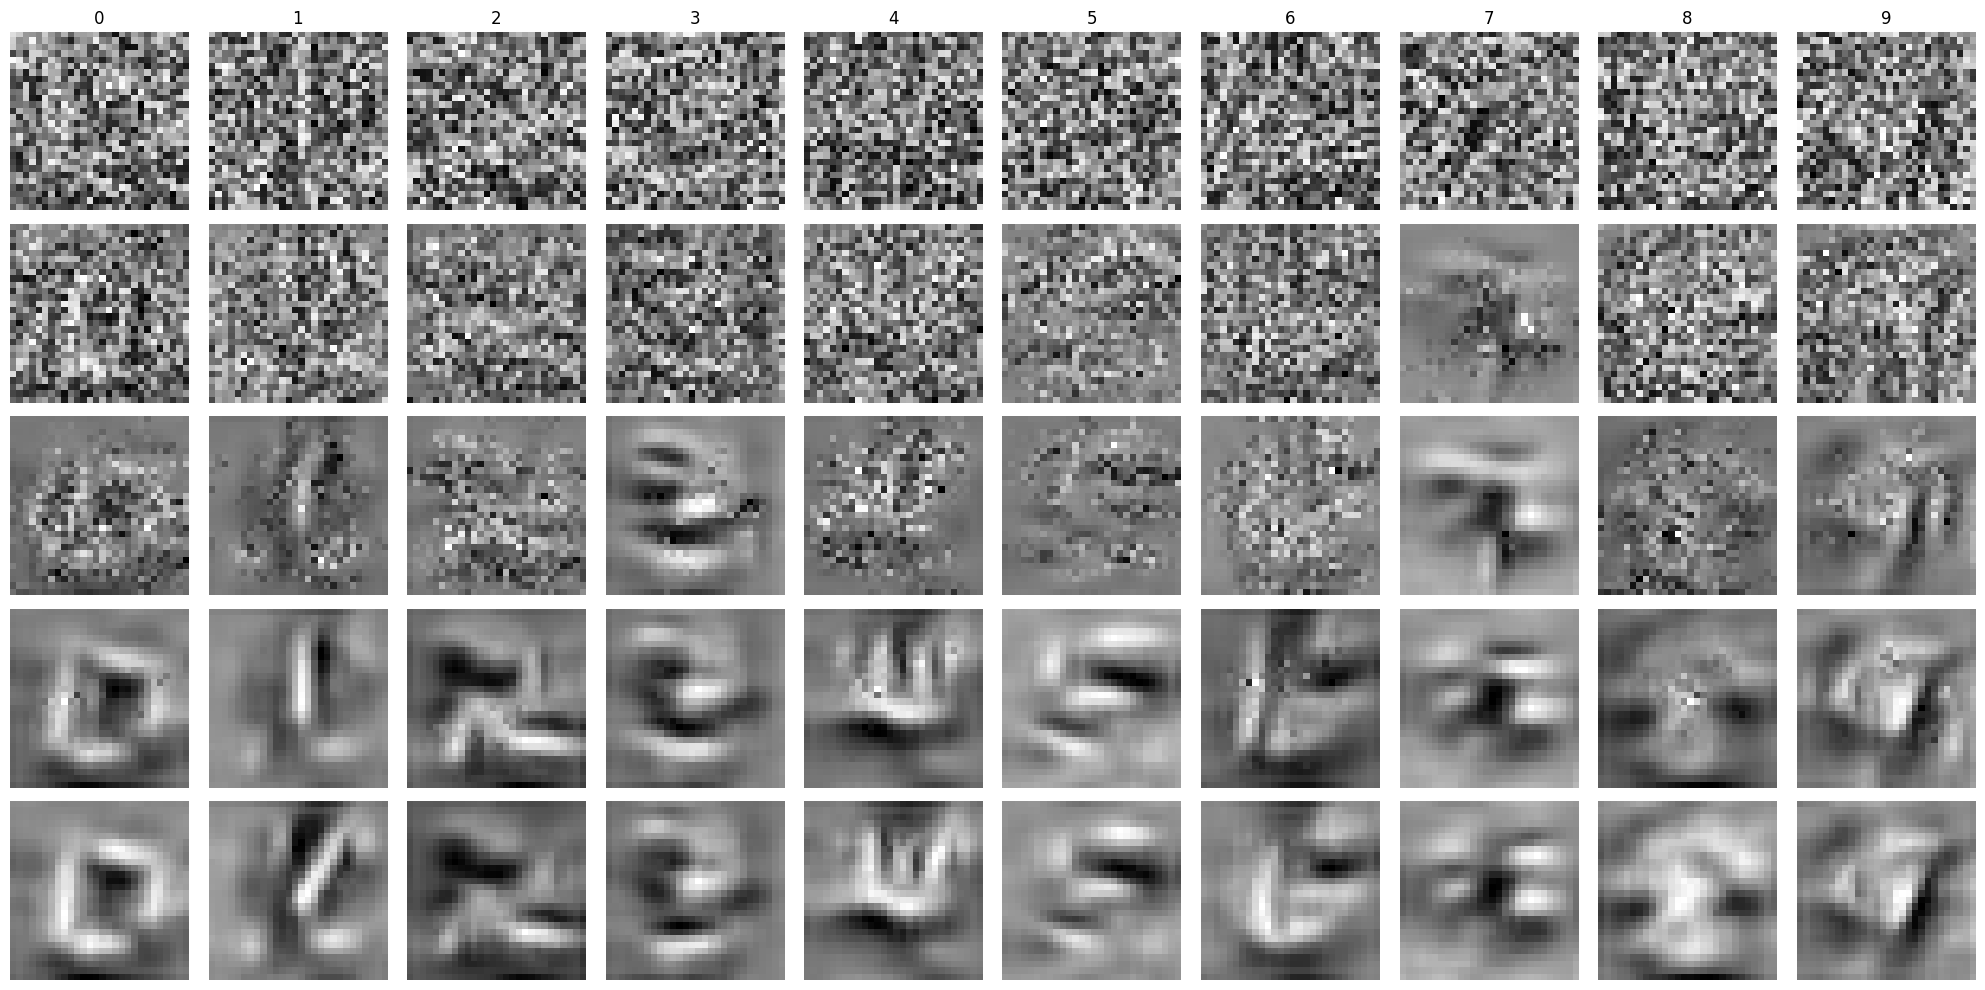

In [17]:
# rysujemy obrazki

fig, axes = plt.subplots(len(lambdas), 10, figsize=(20, 10))
for row_idx, (lambda_val, images) in enumerate(all_images):
    for col_idx in range(10):
        ax = axes[row_idx, col_idx]

        ax.imshow(images[col_idx, 0], cmap='gray')
        if row_idx == 0:
            ax.set_title(f"{col_idx}")

        if col_idx == 0:
            ax.set_ylabel(f"λ={lambda_val:.2e}", rotation=0, labelpad=30)
        ax.axis('off')
plt.tight_layout()
plt.show()

Ciekawe jest, że rzeczywiście przy wzroście lambda obraz jest mniej zaszumiony, natomiast niektóre liczby (na przykład 9, 4, 7 czy 2) nie wyglądają tak jakbyśmy tego oczekiwali. Są rozmazane oraz niepełne. Przy cyfrze 9 brakuje na przykład ogonka.

Dla porównania, poniżej znajdują się obrazki dla MLP i na nich wszystkie cyfry są lepiej widoczne oraz przede wszystkim, są pełne. To znaczy na obrazkach są widoczne całe cyfry, a nie tylko ich składowe.

In [18]:
url = "https://raw.githubusercontent.com/tomczj/ML24_25/main/Convolutional_Neural_Networks/MLP.png"
HTML(f"<img src='{url}' />")

Warto się też przyjrzeć temu dokładniej, bo niektóre liczby (jak już wspomniano) w ogóle nie przypominają tego co byśmy chcieli. Niemniej w kolejnych krokach, sieć poprawnie potrafi je sklasyfikować (poniżej animacja prawdopodobieństw.) Bardzo ciekawe jest też to, że nasza sieć bardzo dobrze dokonuje klasyfikacji. Tutaj chciałbym też dodać, że robiłem kilka eksperymentów i w niektórych przypadkach, sieć z dużo mniejszą pewnością dokonywała klasyfikacji. Nie ustaliłem jednak wtedy seeda i nie byłem w stanie odtworzyć tamtych wyników.

Warto zauważyć, że w szczególności dla wysokich lambd, sieć z mniejszą pewnością potrafi sklasyfikować cyfry 0 i 9, natomiast nie ma problemu z sklasyfikowaniem 7 czy 5. Przyglądając się jednak bliżej obrazkom można zobaczyć, że trójka przypomina troszkę 8, stąd też przedstawiono proces uczenia się sieci dla tych cyfr poniżej (animacja).

In [19]:
url = "https://raw.githubusercontent.com/tomczj/ML24_25/main/Convolutional_Neural_Networks/classification_probabilities_over_time_1.gif"
HTML(f"<img src='{url}' />")

#### Cyfra 3

In [20]:
url = "https://raw.githubusercontent.com/tomczj/ML24_25/main/Convolutional_Neural_Networks/all_lambdas_animation_3.gif"
HTML(f"<img src='{url}' />")

#### Cyfra 8

In [21]:
url = "https://raw.githubusercontent.com/tomczj/ML24_25/main/Convolutional_Neural_Networks/all_lambdas_animation_8.gif"
HTML(f"<img src='{url}' />")

## Podsumowanie dla części I

Po przeanalizowaniu wyników można zauważyć, że w przypadku sieci CNN wygenerowane cyfry są mniej czytelne niż w przypadku MLP. Dla dużych wartości parametru lambda (w niektórych przypadkach) cyfry przestają przypominać rzeczywiste znaki – dotyczy to zwłaszcza cyfr 9, 4, 7 oraz 2. Warto również zaznaczyć, że obrazy uzyskane przy pomocy CNN znacznie mniej przypominają dane ze zbioru MNIST.

Najprostsze wyjaśnienie tej obserwacji wynika z architektury konwolucyjnych sieci neuronowych. Ich głównym celem jest identyfikacja fragmentów obrazów (poprzez zastosowanie filtrów), które niosą największą ilość informacji. Na przykład dla cyfry 9 sieć często generuje jedynie górne kółko, ponieważ jest to najczęściej występujący i najbardziej charakterystyczny fragment tej cyfry, natomiast ogonek może być mylący i przypominać inne cyfry. Interesujący jest także przypadek cyfry 7 – wygenerowany obraz nie przypomina żadnej znanej cyfry, a mimo to sieć poprawnie ją klasyfikuje. Prawdopodobnie wynika to z tego, że CNN nauczyła się rozpoznawać poziomą linię w górnej części obrazu jako cechę charakterystyczną dla cyfry 7.

Podsumowując, obrazy generowane przez CNN zawierają głównie te elementy, które niosą największą wartość informacyjną z punktu widzenia klasyfikatora. W rezultacie nie zawsze przypominają one rzeczywiste cyfry, jednak są skutecznie klasyfikowane przez sieć dzięki temu, że uchwycone zostały najbardziej istotne cechy.

## Część II - Fooling LeNet-5

W tej części pracy zajemiemy się próbą oszukania CNN. W tym celu będzie mało zaburzali obrazki tak aby sieć dokonała błędnej klasyfikacji a następnie dokonamy pokazania tych obrazków.

In [22]:
lambdas = [1.0, 10.0, 25.0, 50.0, 100.0]

# ilość kroków, które wykonamy
steps = 10000
#learnin rate
lr = 0.001

In [23]:
#korzystamy z cpu lub gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#definiujemy model
net = LeNet5()

#pobieramy wytenowany model
net.load_state_dict(torch.load("LeNet5_model.pth"))
net.to(device)

#zamrażamy wagi
net.eval()

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (relu): ReLU()
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=120, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
)

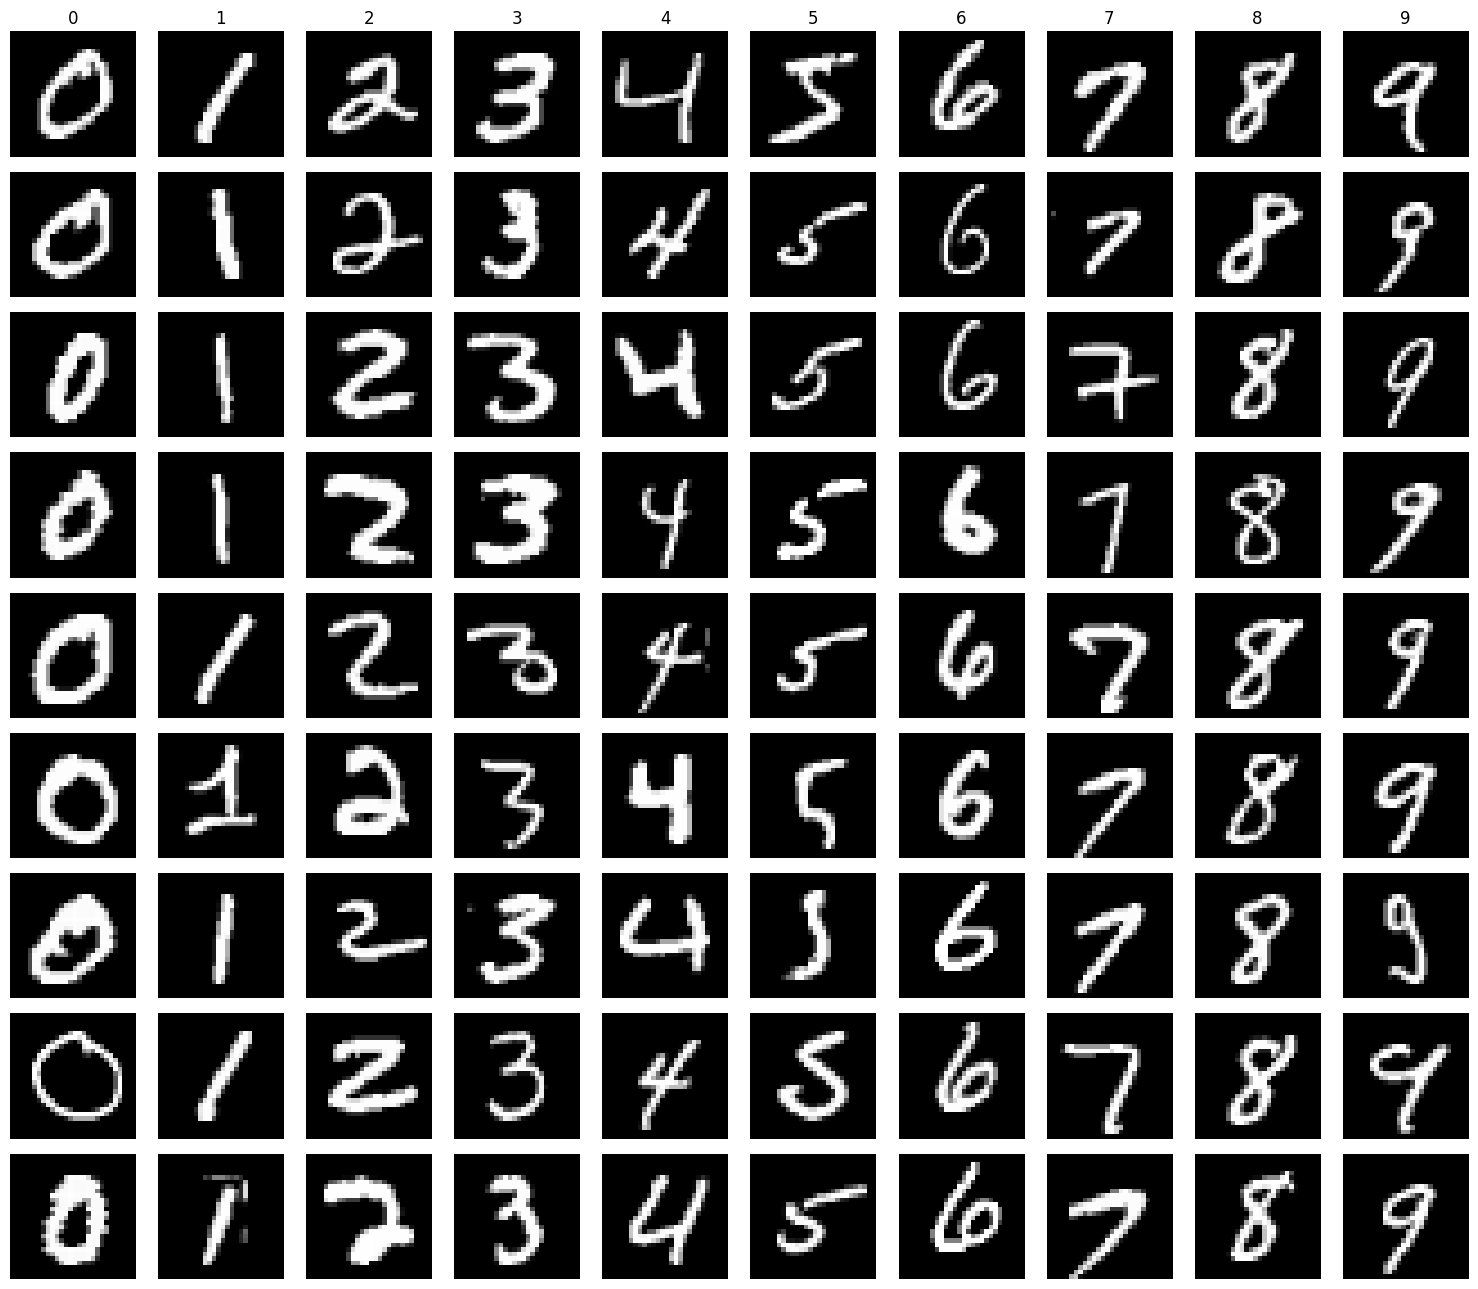

In [24]:
#tutaj będą zapisane cyfyr
digit_images = {i: [] for i in range(10)}

# Bierzemy po 9 obserwacji dla każdej cyfry
for image, label in trainset:
    if len(digit_images[label]) < 9:
        digit_images[label].append(image)
    if all(len(imgs) == 9 for imgs in digit_images.values()):
        break

# Zmieniamy na tensor o wymiarach (10, 9, 1, 28, 28)
digit_tensor = torch.stack([
    torch.stack(digit_images[d]) for d in range(10)
])

# Flatten (90, 1, 28, 28)
batch_size = digit_tensor.shape[0] * digit_tensor.shape[1]  # 10 * 9 = 90
digit_tensor_flat = digit_tensor.view(batch_size, 1, 28, 28)

# Przypisanie błędnych labeli
wrong_class = torch.tensor([8, 2, 3, 6, 5, 4, 7, 1, 9, 0])

# Powtarzamy dla każdego batcha (aby każdy miał takie same przypisanie labeli)
wrong_labels = wrong_class.unsqueeze(1).repeat(1, 9).view(-1)  # shape (90,)

# Pokazujemy wybrane cyfry
fig, axes = plt.subplots(9, 10, figsize=(15, 13))
for digit in range(10):
    for i in range(9):
        ax = axes[i, digit]
        img = digit_tensor[digit, i]
        # Denormalizacjia
        img = img * 0.3081 + 0.1307
        ax.imshow(img.squeeze(), cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title(str(digit), fontsize=12)

plt.tight_layout()
plt.show()


### Trenowanie błędu

In [25]:
net.eval()


# przygotowanie obrazków
digit_tensor_flat = digit_tensor_flat.to(device)
wrong_labels = wrong_labels.to(device)

#tutaj zapiszemy zaszumione obrazki dla poszczególnych lambd
all_perturbed_images = []

#przechodzimy przez wszytskie lambdy
for lambda_l2 in lambdas:

    #inicjalizacja tensora błędów tak aby odpowiadała wymiarom tensora obrazków (zaburzamy każdy piksel)
    deltas = torch.zeros_like(digit_tensor_flat, requires_grad=True)
    optimizer = torch.optim.Adam([deltas], lr=lr)

    # trenujemy błąd
    for step in range(steps):
        optimizer.zero_grad()
        perturbed = (digit_tensor_flat + deltas)
        logits = net(perturbed)
        loss = F.cross_entropy(logits, wrong_labels) + lambda_l2 * deltas.pow(2).mean()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            deltas.clamp_(-digit_tensor_flat, 1 - digit_tensor_flat)


    with torch.no_grad():
        #chcemy aaby obrazki mieściły się w przedziale (0,1) <- tzn dla poszeczeólnych pikseli mamy wartości od 0 do 1
        final_perturbed = (digit_tensor_flat + deltas).clamp(0, 1).cpu()
    all_perturbed_images.append((lambda_l2, final_perturbed))

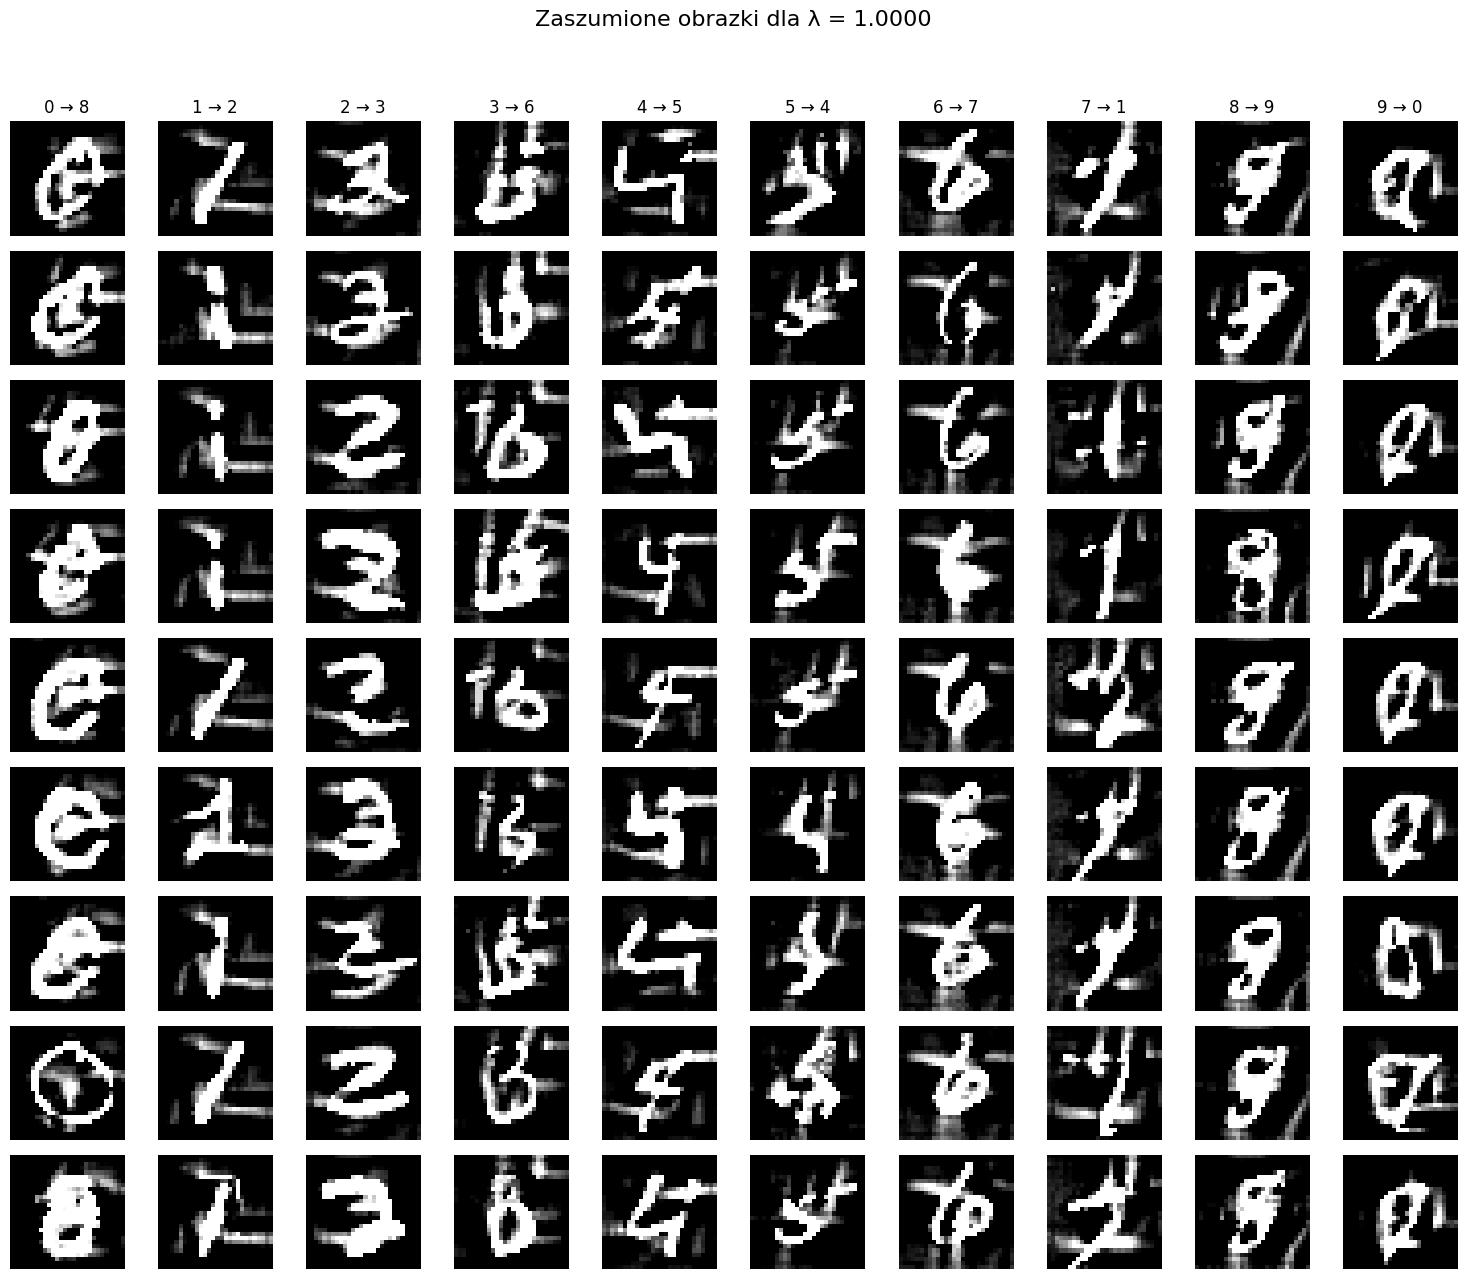

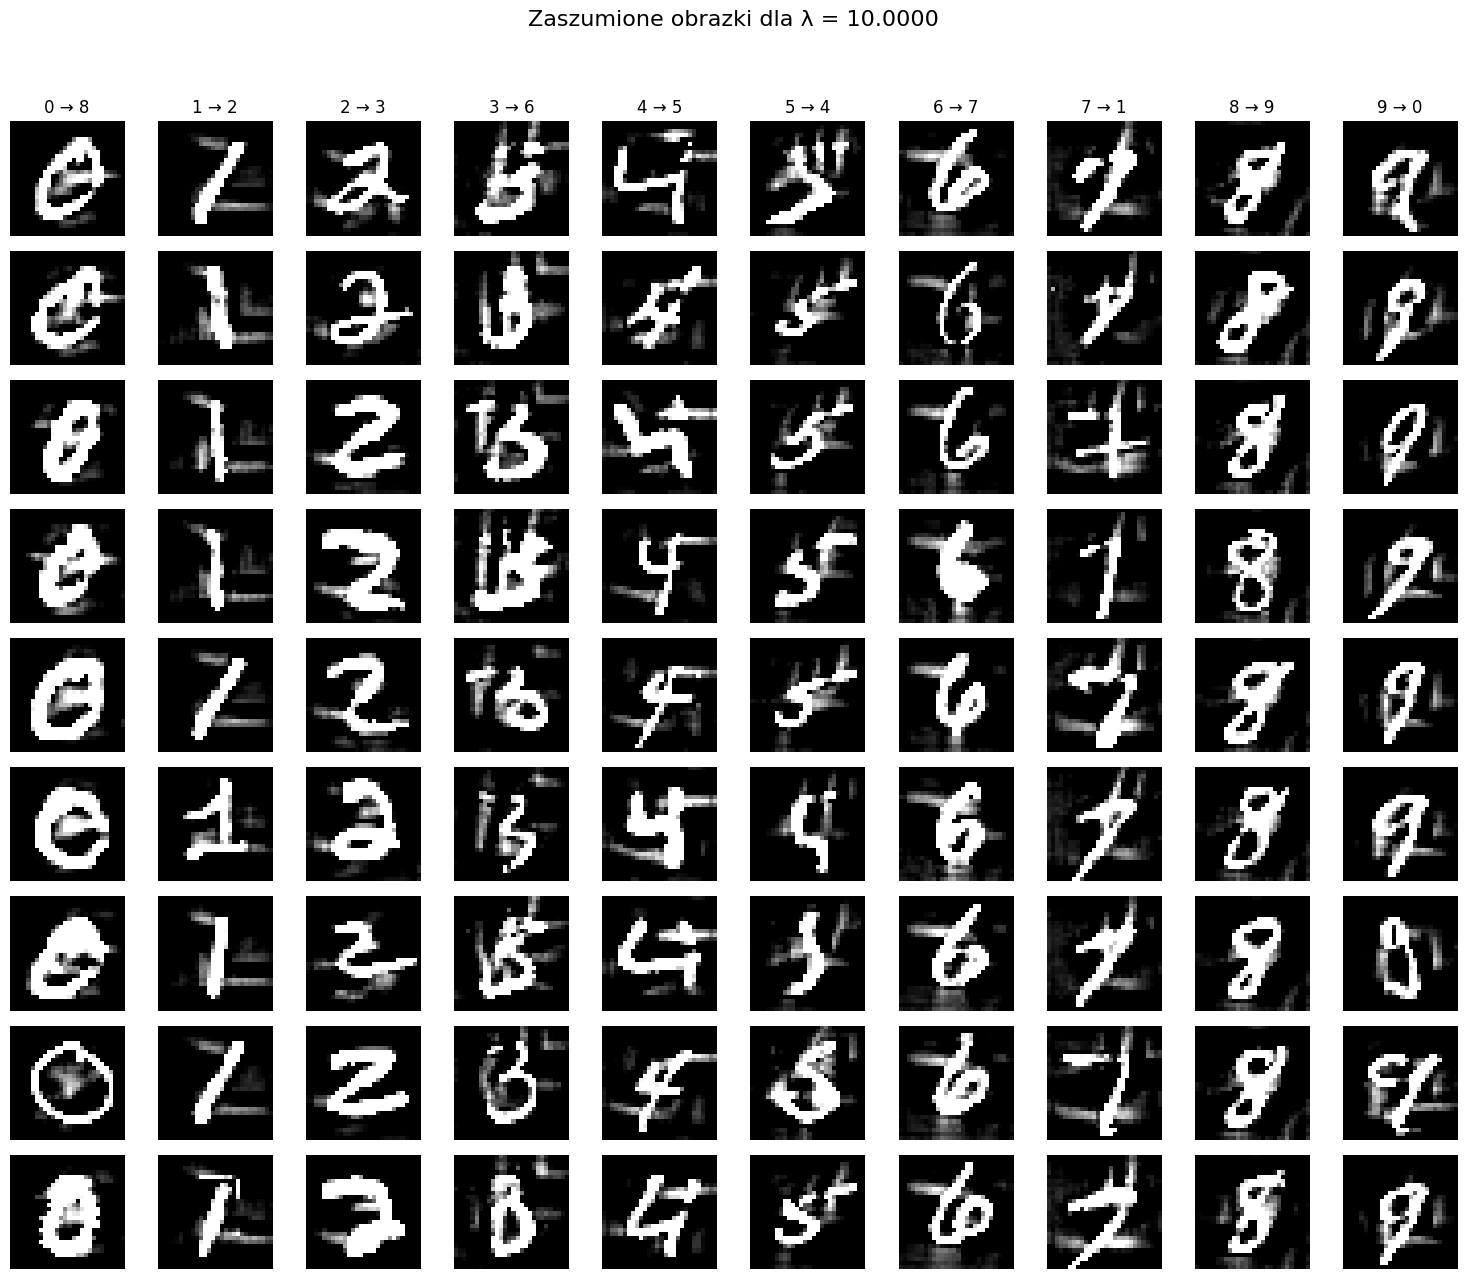

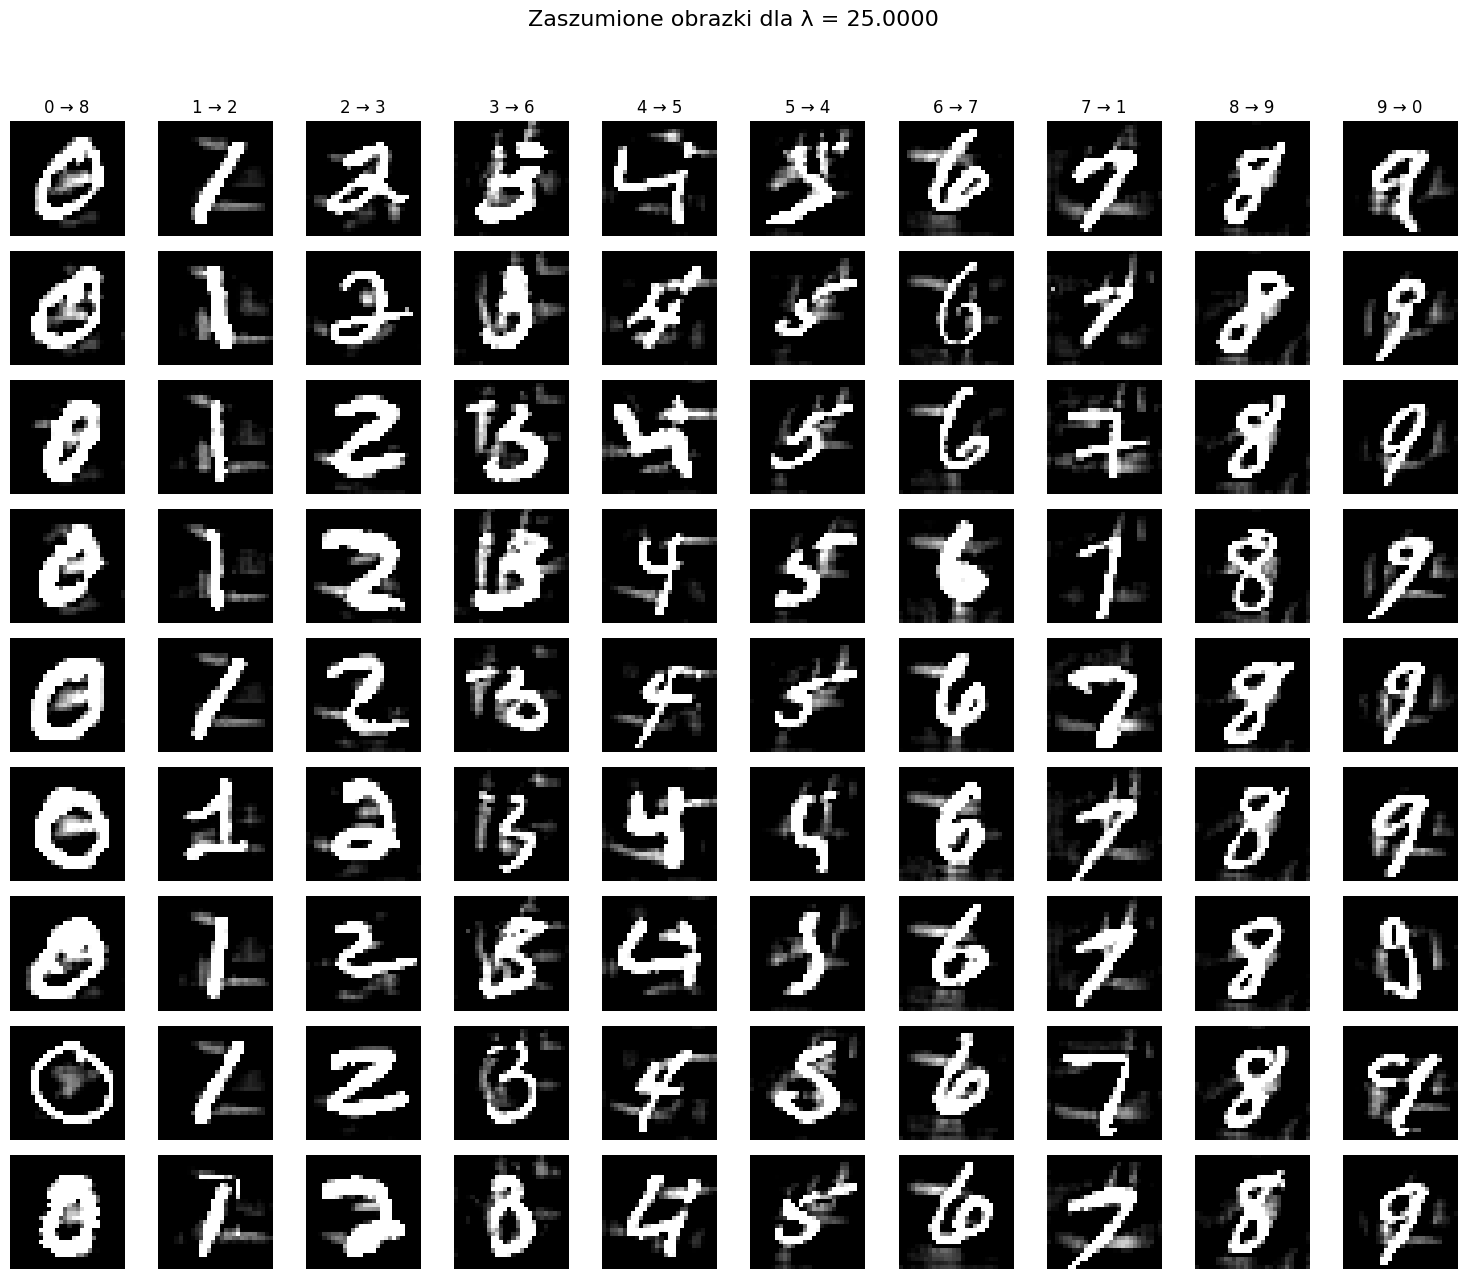

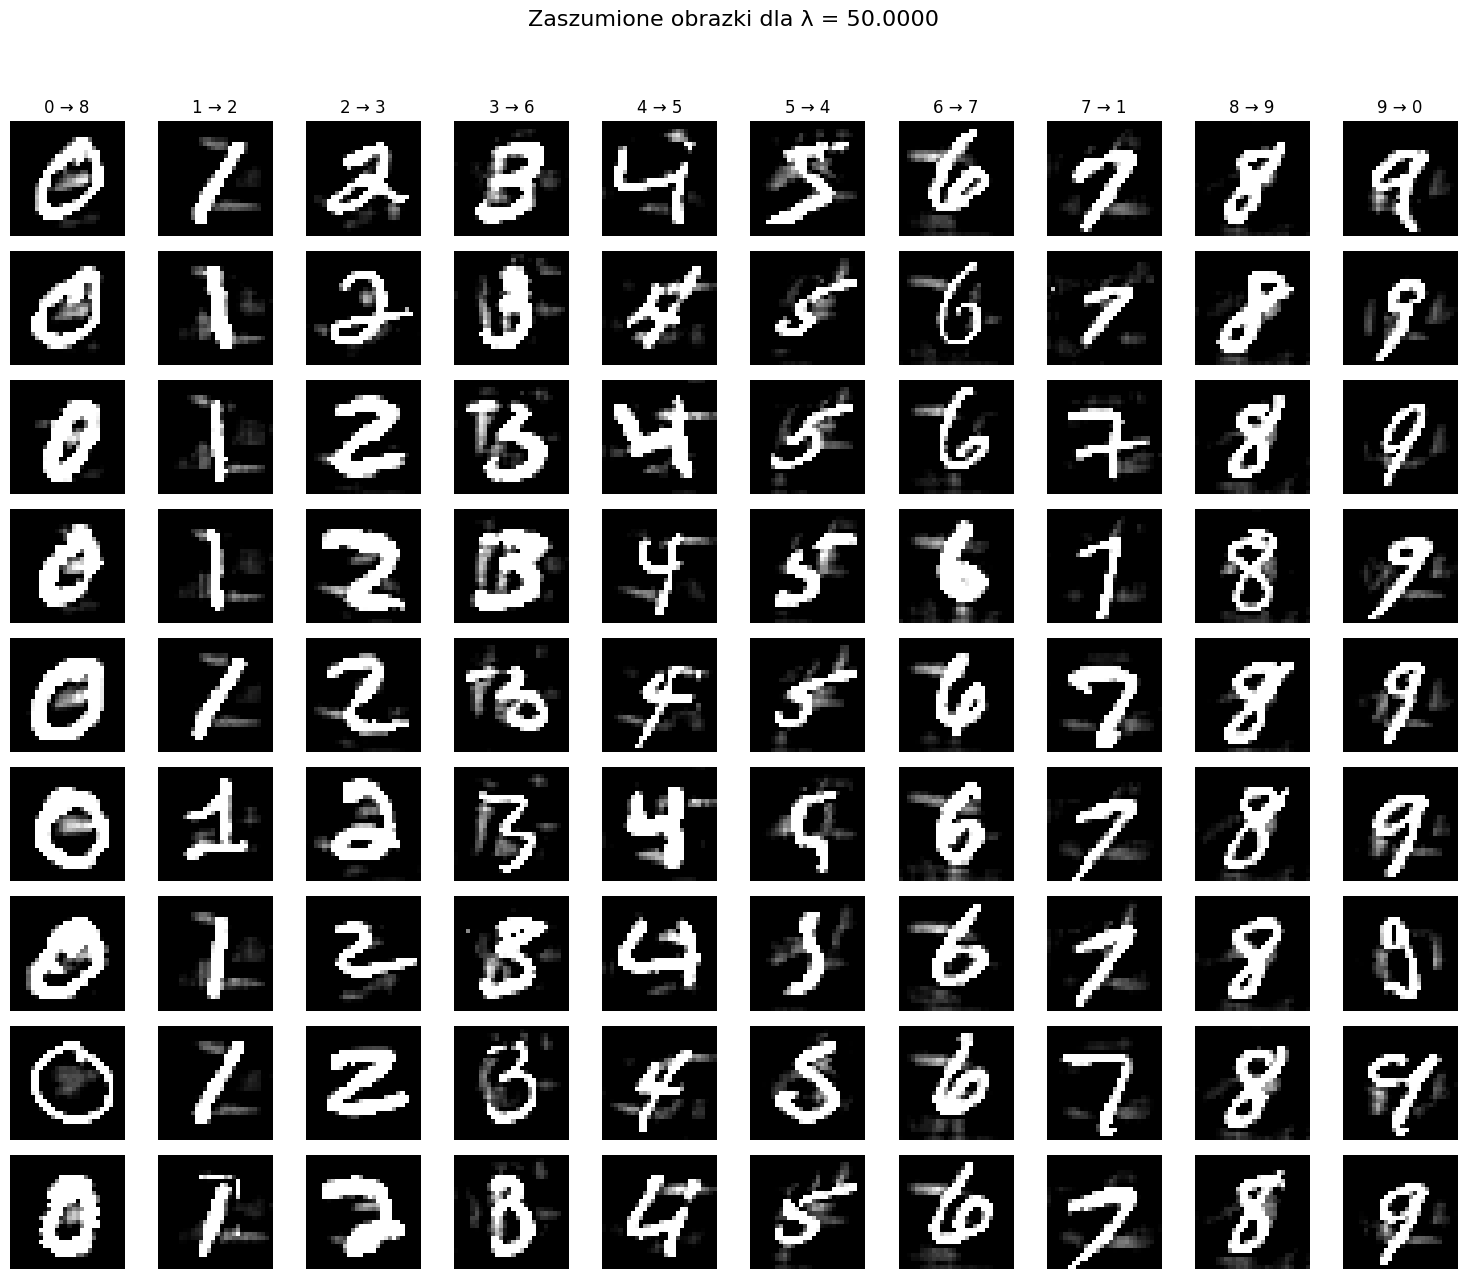

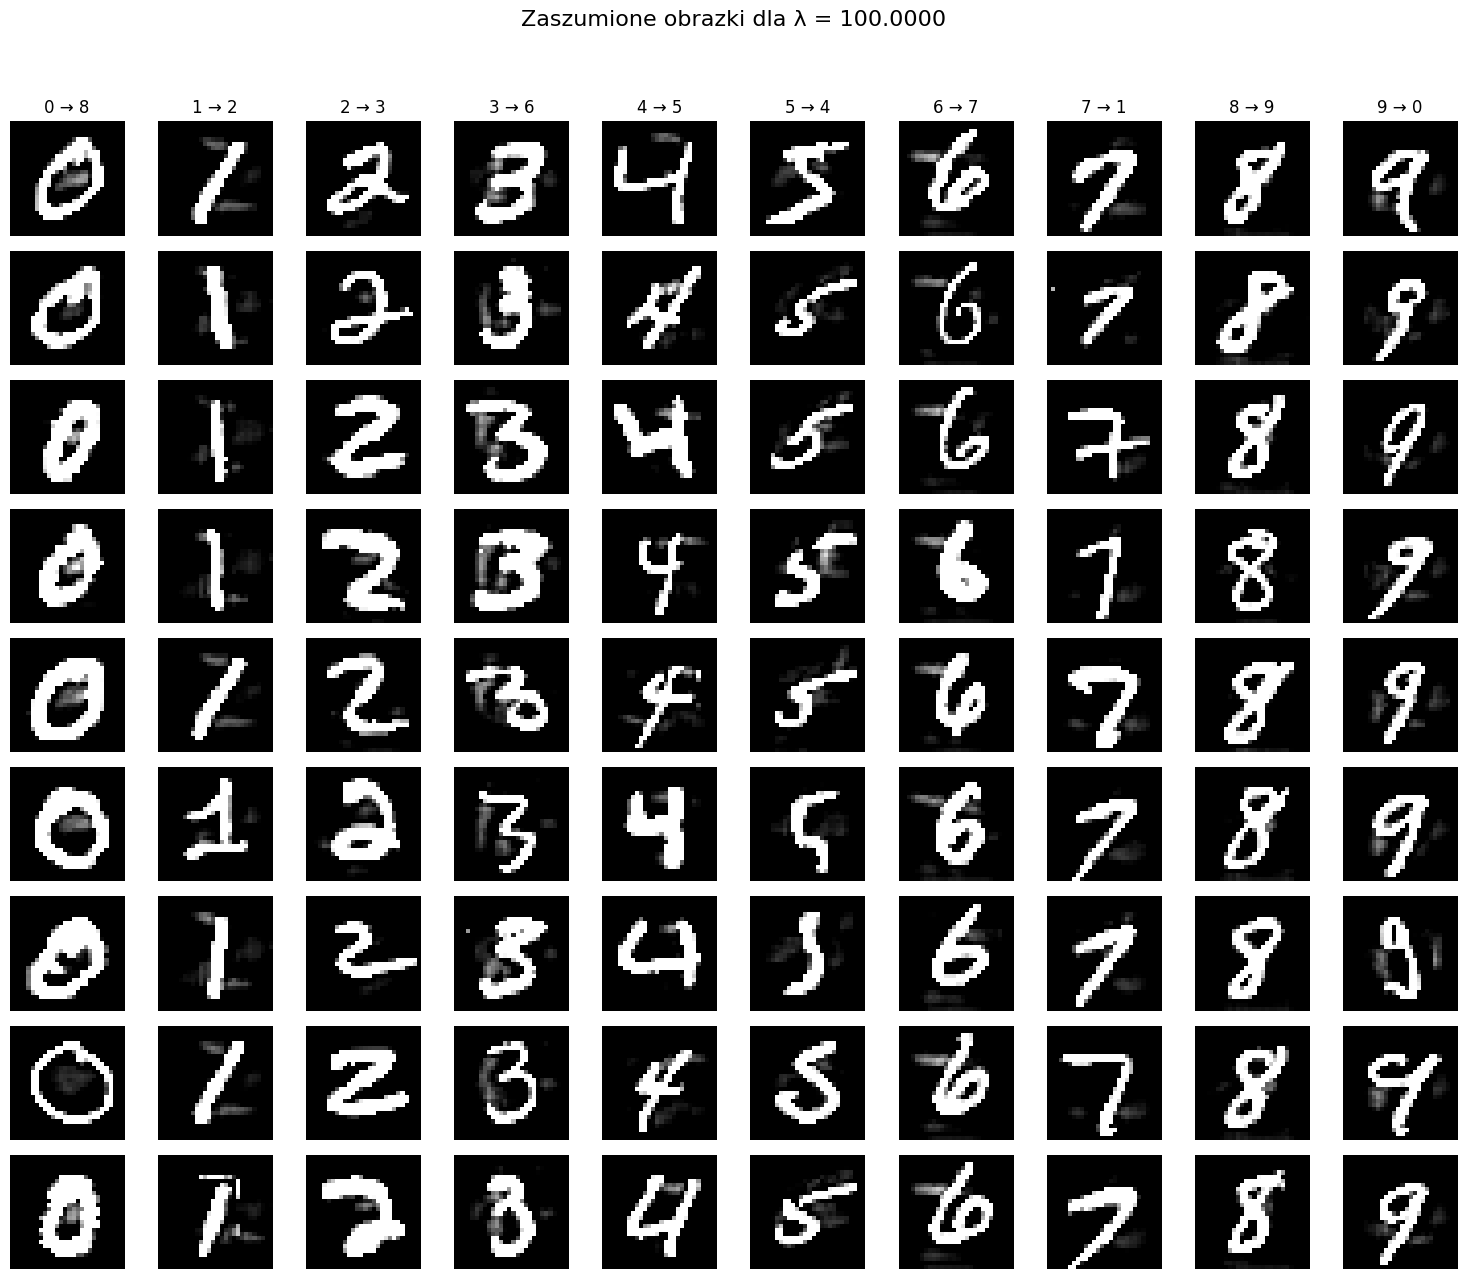

In [26]:
# funkcja do plotowania poturbowanych obrazków

def plot_perturbed_images_for_lambda(perturbed_images, lambda_val, wrong_class):
    imgs = perturbed_images.view(10, 9, 1, 28, 28)

    fig, axes = plt.subplots(9, 10, figsize=(15, 13))
    for digit in range(10):
        for sample in range(9):
            ax = axes[sample, digit]
            img = imgs[digit, sample].squeeze()
            img = img * 0.3081 + 0.1307  # Denormalizacja MNIST
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            if sample == 0:
                ax.set_title(f"{digit} → {wrong_class[digit].item()}", fontsize=12)
    plt.suptitle(f"Zaszumione obrazki dla λ = {lambda_val:.4f}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

for lambda_val, perturbed_imgs in all_perturbed_images[:5]:
    plot_perturbed_images_for_lambda(perturbed_imgs, lambda_val, wrong_class)


Jak można zauważyć, dopiero dla dużych wartości lambda (parametru, który odpowiada za karanie zbyt dużych wartości błędu) zaszumione obrazki zaczynają przypominać te, na których się opierano. Stąd też, ograniczono się do badania obrazków dla parametrów lambda większych od jeden. Na samej górze obrazków pokazano jak zmieniono prawidzwe labele (widoczne są strzałki, które pokazują na jaką klasę zmieniono w treningu tę prawdziwą).

In [27]:
# będziemy pokazywać najlepsze obrazki

def show_best_examples_for_lambda(lambda_val, perturbed_images, digit_tensor, wrong_labels, net, device):
    net.eval()
    perturbed_images = perturbed_images.to(device)
    batch_size = perturbed_images.size(0)

    # Bierzemy pierwszą obserwację z batach dla każdej cyfry
    indices = torch.arange(0, batch_size, 9, device=device)

    originals = digit_tensor[:, 0].to(device)  # shape (10,1,28,28)
    perturbed = perturbed_images[indices]     # shape (10,1,28,28)
    targets = wrong_labels[indices]            # shape (10,)

    # Dokonujemy klasyfikacji obrazków
    with torch.no_grad():
        logits = net(perturbed)
        probs = F.softmax(logits, dim=1)
        confs, preds = torch.max(probs, dim=1)

    # będzemy je teraz chcieli pokazać dla różnych wartości lambda i zestawimy je z oryginalnymi obrazkami
    fig, axes = plt.subplots(10, 2, figsize=(6, 30)) 
    
    for i in range(10):
        # Oryginalny obrazek
        ax_orig = axes[i, 0]
        img_orig = originals[i].cpu() * 0.3081 + 0.1307
        ax_orig.imshow(img_orig.squeeze(), cmap='gray')
        ax_orig.axis('off')
        ax_orig.set_title(f"Orig: {i}")

        # Poturbowany obrazek
        ax_pert = axes[i, 1]
        img_pert = perturbed[i].cpu() * 0.3081 + 0.1307
        ax_pert.imshow(img_pert.squeeze(), cmap='gray')
        ax_pert.axis('off')
        pred_label = preds[i].item()
        conf = confs[i].item()
        ax_pert.set_title(f"Zaszumiony\nPredykcja: {pred_label} ({conf:.2f})\nCel: {targets[i].item()}")

    plt.suptitle(f"Najlepsze obrazki dla λ = {lambda_val:.4f}", fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

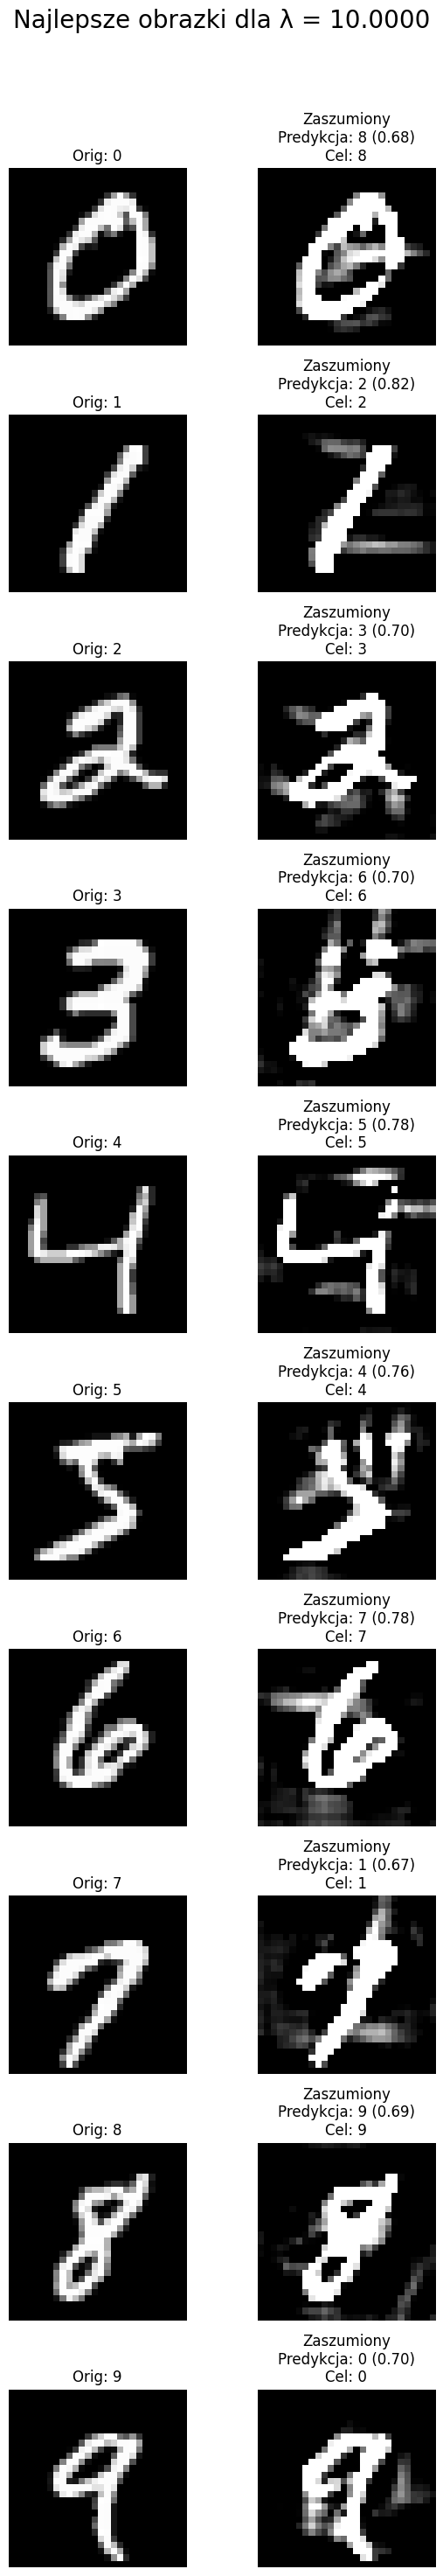

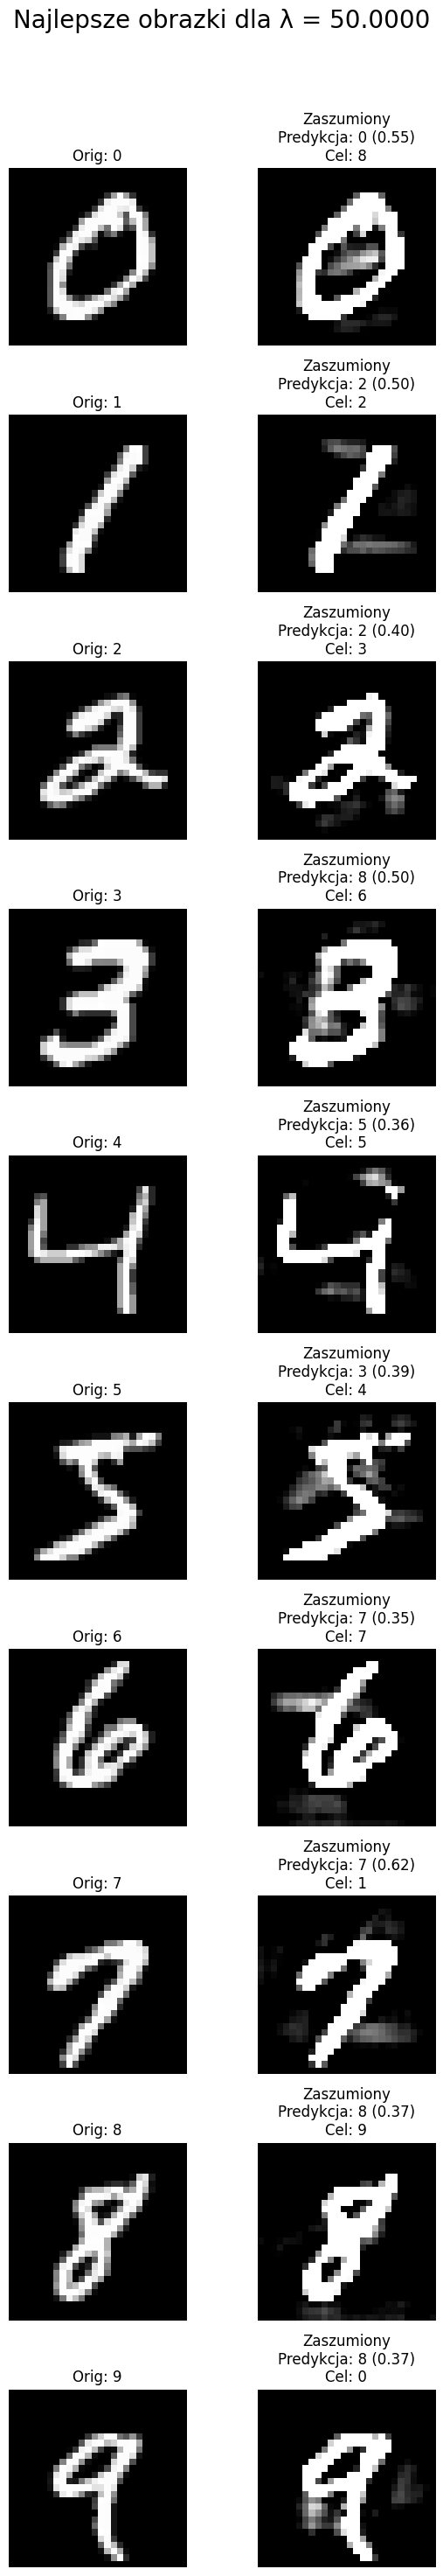

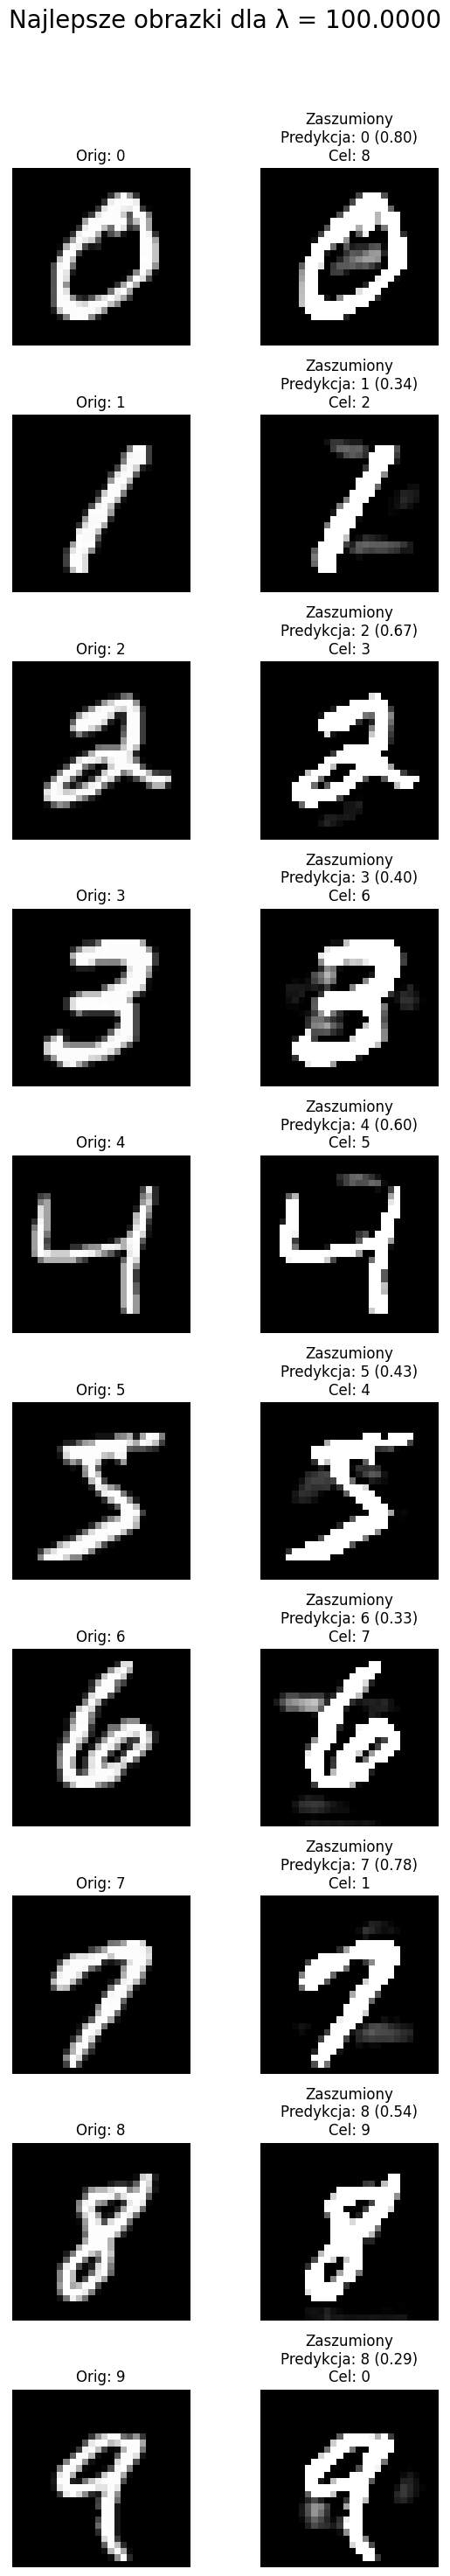

In [28]:
#pokazujemy tylko dla wybranych lambda

chosen_lambda, chosen_images = all_perturbed_images[1]
show_best_examples_for_lambda(chosen_lambda, chosen_images, digit_tensor, wrong_labels, net, device)

chosen_lambda, chosen_images = all_perturbed_images[3]
show_best_examples_for_lambda(chosen_lambda, chosen_images, digit_tensor, wrong_labels, net, device)

chosen_lambda, chosen_images = all_perturbed_images[4]
show_best_examples_for_lambda(chosen_lambda, chosen_images, digit_tensor, wrong_labels, net, device)

Warto zauważyć, że wraz ze wzrostem lambdy, CNN nie daje się aż tak oszukać przy klasyfikacji poszczególnych cyfr. Dla małych wartości parametru regularyzującego udaje się nam całkowicie oszukać sieć (wszystkie klasyfikacje są błędne.)

In [29]:
# policzymy sobie teraz z jakim sukcsem udało nam się zwieść sieć neuronową
net.eval()

#tutaj zapisujemy wyniki dla poszczególnych lambda
results = []

for lambda_val, perturbed_images in all_perturbed_images:
    perturbed_images = perturbed_images.to(device)
    targets = wrong_labels.to(device)

    #liczymy z jakim przekonaniem sieć klasyfikuje cyfry
    with torch.no_grad():
        logits = net(perturbed_images)
        preds = torch.argmax(logits, dim=1)
        confs = F.softmax(logits, dim=1).max(dim=1).values

    # liczymy success rate (czyli czy udało nam się zwieść sieć neuronową) oraz avergae confidence dla sieci neuronowej
    successful = (preds == targets)
    success_rate = successful.float().mean().item()
    avg_conf = confs.mean().item()

    results.append({
        'lambda': lambda_val,
        'success_rate': success_rate,
        'avg_confidence': avg_conf
    })

df = pd.DataFrame(results)
df

,lambda,success_rate,avg_confidence
0,1.0,1.000000,0.947302
1,10.0,1.000000,0.733539
2,25.0,0.900000,0.518978
3,50.0,0.488889,0.414030
4,100.0,0.022222,0.504049


Jak widać w powyższej tabeli, wraz ze wzrostem parametru regularyzacyjengo coraz trudniej jest nam oszukać CNN (co było spodziewane). Dla dużych wartości lambda, prawie w ogóle nam się to nie udaje.

Poniżej jeszcze zaprezentowana jest animacja (przy innym $\textit{learning rate}$) jak wygląda średnie prawdopodobieńwto klasyfikacji poszczególnych cyfr dla różnych wartości parametru regularyzayjengo (uśrednione po ilości obserwacji, to znaczy dla każdej cyfyr mamy 9 obserwacji i bierzemy średnie prawdopodobieńwto klasyfikacji dla tych 9 obserwacji na każdą cyfrę.)

In [30]:
url = "https://raw.githubusercontent.com/tomczj/ML24_25/main/Convolutional_Neural_Networks/learning_confidence_animation.gif"
HTML(f"<img src='{url}' />")

## Podsumowanie dla części II

Jak można było zauważyć, wraz ze wzrostem parametru regularyzacyjnego (czyli silniejszym karaniem dużych zmian w obrazie) uzyskiwaliśmy czytelniejsze obrazki, bardziej przypominające oryginały. Jednocześnie jednak znacznie trudniej było oszukać sieć CNN, podając jej nieprawdziwe etykiety.

W szczególności, dla małych wartości parametru lambda atak był bardzo skuteczny – CNN błędnie klasyfikowała wszystkie obrazy. Natomiast dla dużych wartości lambda tylko niewielka część obrazów została błędnie sklasyfikowana (około 2%). Szczegółowe wyniki przedstawiliśmy wcześniej w tabeli prezentującej skuteczność ataku (success rate of attacks).

Pokazaliśmy również, jak wyglądają zaszumione obrazki w porównaniu do oryginałów, a także przeanalizowaliśmy, w jaki sposób CNN klasyfikuje poszczególne przykłady. Dla większych wartości lambda sieć potrafiła poprawnie przyporządkować etykiety nawet mimo obecności niewielkich zakłóceń.

Podsumowując, wzrost parametru regularyzującego powodował, że generowane obrazy były bardziej podobne do oryginalnych, ale jednocześnie $\textit{atak na sieć}$ stawał się coraz mniej skuteczny.


# Animacje

In [31]:
raise ValueError("Ta linijka zapobiega przypadkowemu odpaleniu się animacji")

ValueError: Ta linijka zapobiega przypadkowemu odpaleniu się animacji

#### Animacja do zadania pierwszego wraz z różnymi parametrami regularyzującymi

In [ ]:
#definiujemy model
net = LeNet5()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#pobieramy wytenowany model
net.load_state_dict(torch.load("LeNet5_model.pth"))
net.to(device)

#zamrażamy wagi
net.eval()

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (relu): ReLU()
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=120, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
)

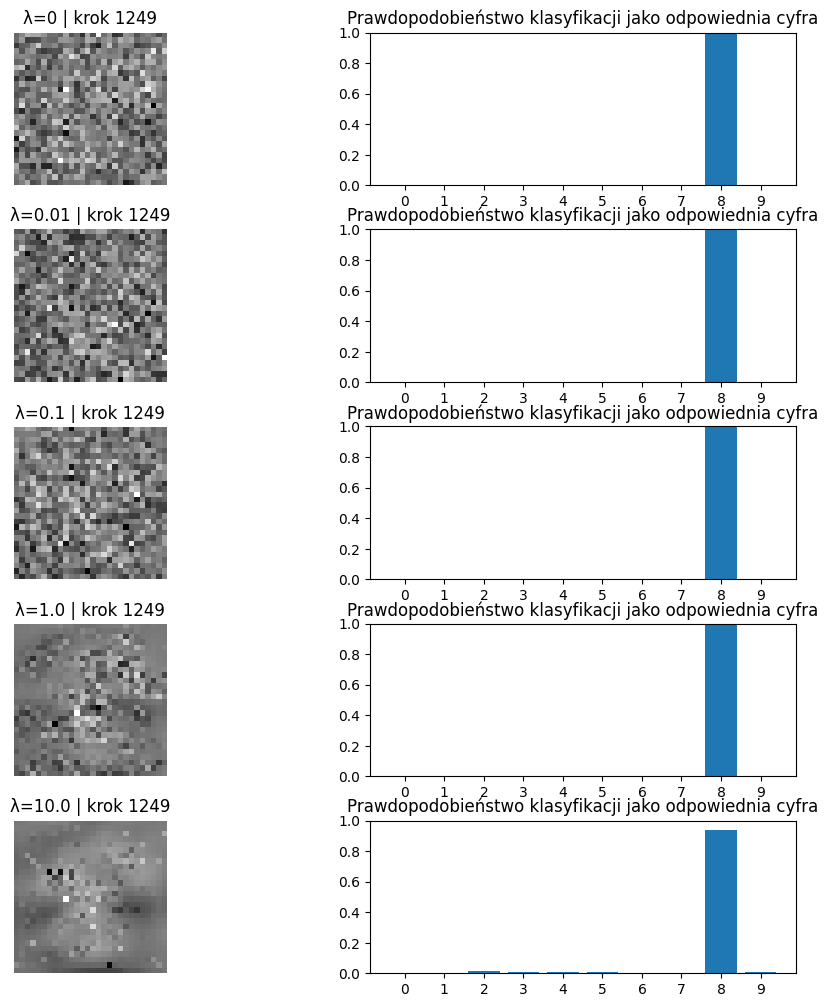

In [ ]:
#Konfiguracja
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target_digit = 8  # wybrana cyfra, którą będziemy animować
steps = 1250     # liczba kroków optymalizacji
lr = 0.003        # learning rate
lambdas = [0, 0.01, 0.1, 1.0, 10.0]  # lista różnych wartości lambda

#Przygotowanie modelu
net.eval()

#Struktury danych do przechowywania ramek dla każdej lambdy
all_image_frames = []       # lista: dla każdej lambdy -> lista obrazków
all_probability_frames = [] # lista: dla każdej lambdy -> lista prawdopodobieństw

#Optymalizacja osobno dla każdej lambdy
for lambda_l2 in lambdas:
    # tworzymy losowe obrazki i optymalizator
    dr_images = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)
    targets = torch.arange(10, device=device)
    optimizer = torch.optim.Adam([dr_images], lr=lr)

    # listy do przechowywania wyników dla tej lambdy
    image_frames = []
    probability_frames = []

    # pętla optymalizacji
    for step in range(steps):
        optimizer.zero_grad()
        logits = net(dr_images)
        loss = F.cross_entropy(logits, targets) + lambda_l2 * dr_images.pow(2).mean()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            img = dr_images[target_digit].detach().cpu().squeeze().numpy()
            img = (img - img.min()) / (img.max() - img.min() + 1e-5)  # skalujemy do [0, 1]
            probs = F.softmax(logits[target_digit], dim=0).cpu().numpy()
            image_frames.append(img)
            probability_frames.append(probs)

    # zapisujemy wyniki do zbiorczych list
    all_image_frames.append(image_frames)
    all_probability_frames.append(probability_frames)

#Przygotowanie wykresu
fig, axes = plt.subplots(len(lambdas), 2, figsize=(10, 10))

def update_all(frame_idx):
    for row_idx in range(len(lambdas)):
        ax_img = axes[row_idx, 0]
        ax_bar = axes[row_idx, 1]

        # czyścimy stare dane
        ax_img.clear()
        ax_bar.clear()

        # pobieramy odpowiednią klatkę z obrazkiem i wykresem słupkowym
        img = all_image_frames[row_idx][frame_idx]
        probs = all_probability_frames[row_idx][frame_idx]

        # obrazek
        ax_img.imshow(img, cmap='gray', vmin=0, vmax=1)
        ax_img.set_title(f"λ={lambdas[row_idx]} | krok {frame_idx}")
        ax_img.axis('off')

        # wykres słupkowy
        ax_bar.bar(np.arange(10), probs)
        ax_bar.set_ylim(0, 1)
        ax_bar.set_title("Prawdopodobieństwo klasyfikacji jako odpowiednia cyfra")
        ax_bar.set_xticks(np.arange(10))

#Tworzymy animację
ani = FuncAnimation(fig, update_all, frames=steps, interval=50)
plt.tight_layout()
ani.save(f"all_lambdas_animation_{target_digit}.gif", writer=PillowWriter(fps=40))
plt.show()

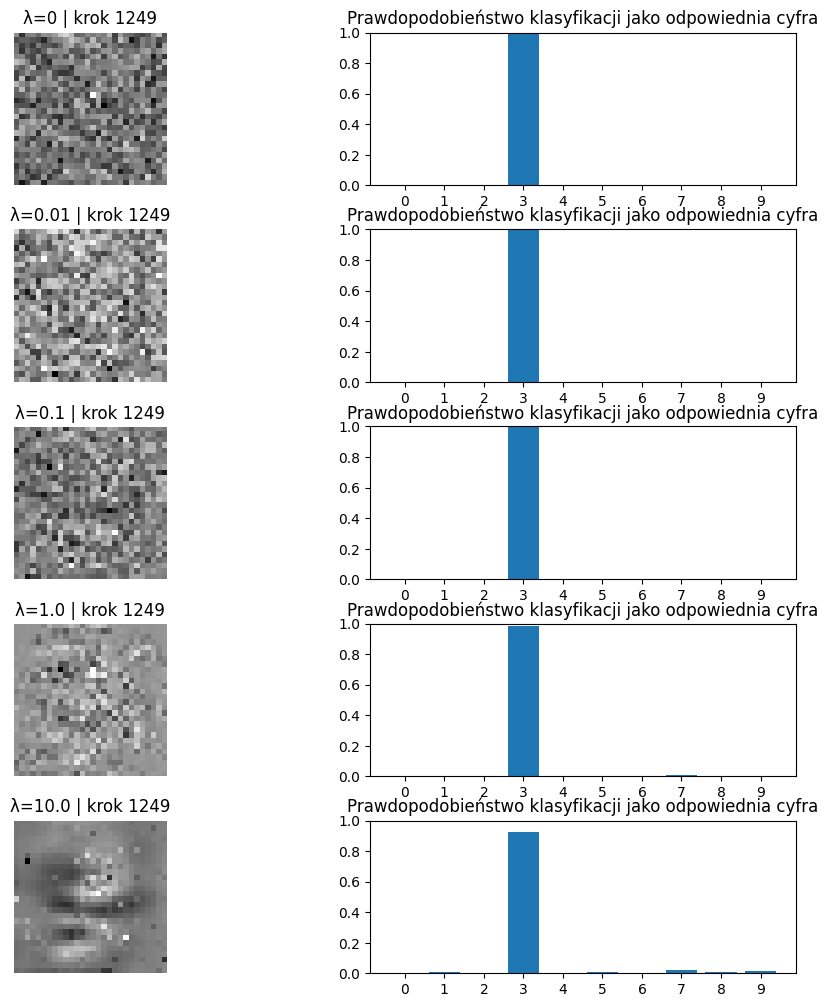

In [ ]:
#Konfiguracja
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target_digit = 3  # wybrana cyfra, którą będziemy animować
steps = 1250    # liczba kroków optymalizacji
lr = 0.003        # learning rate
lambdas = [0, 0.01, 0.1, 1.0, 10.0]  # lista różnych wartości lambda

#Przygotowanie modelu
net.eval()

#Struktury danych do przechowywania ramek dla każdej lambdy
all_image_frames = []       # lista: dla każdej lambdy -> lista obrazków
all_probability_frames = [] # lista: dla każdej lambdy -> lista prawdopodobieństw

#Optymalizacja osobno dla każdej lambdy
for lambda_l2 in lambdas:
    # tworzymy losowe obrazki i optymalizator
    dr_images = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)
    targets = torch.arange(10, device=device)
    optimizer = torch.optim.Adam([dr_images], lr=lr)

    # listy do przechowywania wyników dla tej lambdy
    image_frames = []
    probability_frames = []

    # pętla optymalizacji
    for step in range(steps):
        optimizer.zero_grad()
        logits = net(dr_images)
        loss = F.cross_entropy(logits, targets) + lambda_l2 * dr_images.pow(2).mean()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            img = dr_images[target_digit].detach().cpu().squeeze().numpy()
            img = (img - img.min()) / (img.max() - img.min() + 1e-5)  # skalujemy do [0, 1]
            probs = F.softmax(logits[target_digit], dim=0).cpu().numpy()
            image_frames.append(img)
            probability_frames.append(probs)

    # zapisujemy wyniki do zbiorczych list
    all_image_frames.append(image_frames)
    all_probability_frames.append(probability_frames)

#Przygotowanie wykresu
fig, axes = plt.subplots(len(lambdas), 2, figsize=(10, 10))

def update_all(frame_idx):
    for row_idx in range(len(lambdas)):
        ax_img = axes[row_idx, 0]
        ax_bar = axes[row_idx, 1]

        # czyścimy stare dane
        ax_img.clear()
        ax_bar.clear()

        # pobieramy odpowiednią klatkę z obrazkiem i wykresem słupkowym
        img = all_image_frames[row_idx][frame_idx]
        probs = all_probability_frames[row_idx][frame_idx]

        # obrazek
        ax_img.imshow(img, cmap='gray', vmin=0, vmax=1)
        ax_img.set_title(f"λ={lambdas[row_idx]} | krok {frame_idx}")
        ax_img.axis('off')

        # wykres słupkowy
        ax_bar.bar(np.arange(10), probs)
        ax_bar.set_ylim(0, 1)
        ax_bar.set_title("Prawdopodobieństwo klasyfikacji jako odpowiednia cyfra")
        ax_bar.set_xticks(np.arange(10))

#Tworzymy animację
ani = FuncAnimation(fig, update_all, frames=steps, interval=50)
plt.tight_layout()
ani.save(f"all_lambdas_animation_{target_digit}.gif", writer=PillowWriter(fps=40))
plt.show()

### Animowanie histogramów - task 1

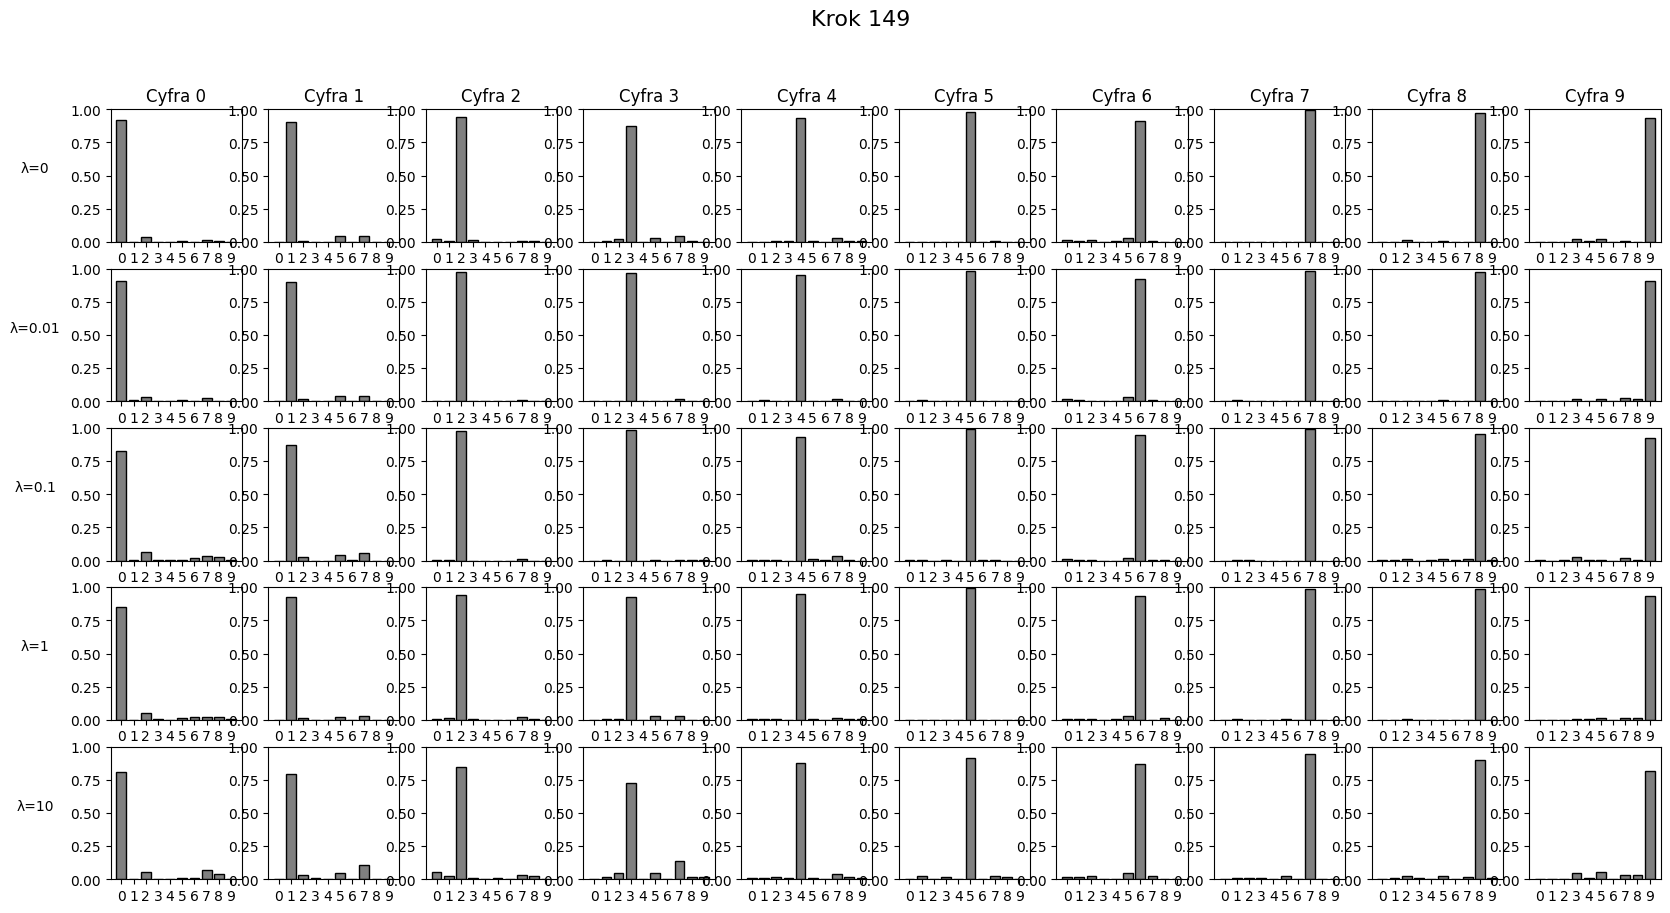

In [ ]:
# Konfiguracja
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
steps = 150
lr = 0.0025
lambdas = [0, 0.01, 0.1, 1.0, 10.0]

# Załóżmy, że net to wytrenowany klasyfikator
net.eval()

# Przechowywanie: [lambda][cyfra][krok] = tablica długości 10 (prawdopodobieństwa)
all_probabilities = [[[] for _ in range(10)] for _ in lambdas]

# Optymalizacja obrazów
for lambda_idx, lambda_l2 in enumerate(lambdas):
    # Jeden obraz dla każdej cyfry
    dr_images = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)
    targets = torch.arange(10, device=device)
    optimizer = torch.optim.Adam([dr_images], lr=lr)

    for step in range(steps):
        optimizer.zero_grad()
        logits = net(dr_images)
        loss = F.cross_entropy(logits, targets) + lambda_l2 * dr_images.pow(2).mean()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            probs = F.softmax(logits, dim=1).cpu().numpy()  # kształt: (10, 10)
            for digit in range(10):
                all_probabilities[lambda_idx][digit].append(probs[digit])

# Przygotowanie animacji
fig, axes = plt.subplots(len(lambdas), 10, figsize=(20, 10))
for ax in axes.flat:
    ax.set_ylim(0, 1)
    ax.set_xticks(range(10))
    ax.set_yticks([0, 0.5, 1])

def update(frame):
    for lambda_idx in range(len(lambdas)):
        for digit in range(10):
            ax = axes[lambda_idx][digit]
            ax.clear()
            ax.set_ylim(0, 1)
            ax.set_xticks(range(10))

            probs = all_probabilities[lambda_idx][digit][frame]
            ax.bar(np.arange(10), probs, color='gray', edgecolor='black')

            if lambda_idx == 0:
                ax.set_title(f"Cyfra {digit}")
            if digit == 0:
                ax.set_ylabel(f"λ={lambdas[lambda_idx]:.2g}", rotation=0, labelpad=25)

    fig.suptitle(f"Krok {frame}", fontsize=16)

ani = FuncAnimation(fig, update, frames=steps, interval=50)

# Zapis do GIFa
ani.save("classification_probabilities_over_time_1.gif", writer=PillowWriter(fps=20))
plt.show()


### Animowanie histogramów - task 2

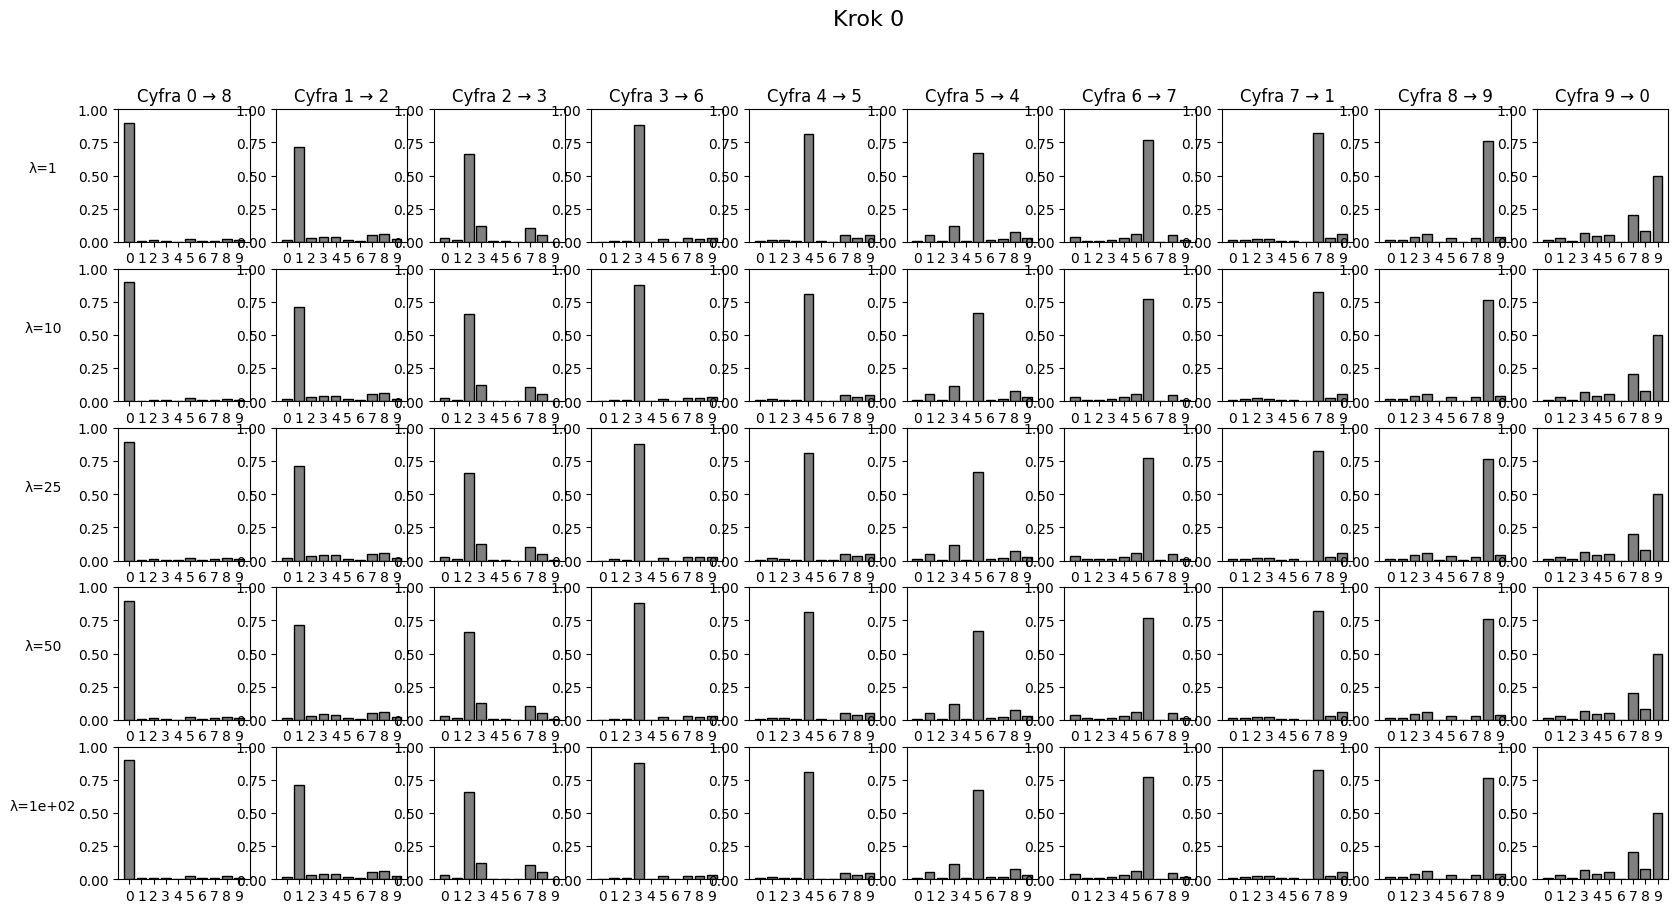

In [ ]:
# Zakładamy, że istnieją: digit_tensor_flat (90,1,28,28), net (w trybie eval), device
net.eval()
steps = 200
lr = 0.005
lambdas = [1, 10.0, 25.0, 50.0, 100]

digit_tensor_flat = digit_tensor_flat.to(device)
wrong_labels = wrong_labels.to(device)

# Przygotowanie miejsca na wyniki
# Format: [lambda_idx][cyfra][krok] = średni wektor prawdopodobieństw (10,)
all_probabilities = [[[] for _ in range(10)] for _ in lambdas]

for lambda_idx, lambda_l2 in enumerate(lambdas):
    deltas = torch.zeros_like(digit_tensor_flat, requires_grad=True)
    optimizer = torch.optim.Adam([deltas], lr=lr)

    for step in range(steps):
        optimizer.zero_grad()
        perturbed = (digit_tensor_flat + deltas).clamp(0, 1)
        logits = net(perturbed)
        
        # etykiety błędne
        loss = F.cross_entropy(logits, wrong_labels.to(device)) + lambda_l2 * deltas.pow(2).mean()
        loss.backward()
        optimizer.step()

        # Ograniczenie perturbacji, żeby nie przekroczyła dozwolonego zakresu obrazu
        with torch.no_grad():
            deltas.clamp_(-digit_tensor_flat, 1 - digit_tensor_flat)

        # Zapis prawdopodobieństw
        with torch.no_grad():
            probs = F.softmax(logits, dim=1)  # kształt: (90, 10)

            for digit in range(10):
                start = digit * 9
                end = start + 9
                digit_probs = probs[start:end]  # kształt: (9, 10)
                mean_prob = digit_probs.mean(dim=0).cpu().numpy()  # kształt: (10,)
                all_probabilities[lambda_idx][digit].append(mean_prob)

#Animacja
fig, axes = plt.subplots(len(lambdas), 10, figsize=(20, 10))

for ax in axes.flat:
    ax.set_ylim(0, 1)
    ax.set_xticks(range(10))
    ax.set_yticks([0, 0.5, 1])

# Definicja błędnych klas do pokazania w tytułach
wrong_class = torch.tensor([8, 2, 3, 6, 5, 4, 7, 1, 9, 0])

def update(frame):
    for lambda_idx in range(len(lambdas)):
        for digit in range(10):
            ax = axes[lambda_idx][digit]
            ax.clear()
            ax.set_ylim(0, 1)
            ax.set_xticks(range(10))

            probs = all_probabilities[lambda_idx][digit][frame]
            ax.bar(np.arange(10), probs, color='gray', edgecolor='black')

            if lambda_idx == 0:
                ax.set_title(f"Cyfra {digit} → {wrong_class[digit].item()}")
            if digit == 0:
                ax.set_ylabel(f"λ={lambdas[lambda_idx]:.2g}", rotation=0, labelpad=25)

    fig.suptitle(f"Krok {frame}", fontsize=16)

ani = FuncAnimation(fig, update, frames=steps, interval=80)

# Zapis
ani.save("learning_confidence_animation.gif", writer=PillowWriter(fps=20))
